In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

# Setup

In [2]:
model = BabyMAKROModelClass(name='baseline') # create an instance of the model

In [3]:
par = model.par
ss = model.ss
sol = model.sol

# Find steady state

In [4]:
model.find_ss(0.50,do_print=True)

ss.S = 7.44
ss.L = 56.28
ss.delta_L = 0.07
ss.v = 7.54
ss.m_v = 0.49
ss.r_K = 0.16
ss.r_ell = 1.66
ss.r_E = 1.00
ss.ell = 56.09
ss.w = 1.65
ss.K = 81.33
ss.I = 8.13
ss.Y = 158.43
ss.G = 39.61
ss.B_G = 0.00
ss.tau = 0.52
solving for household behavior: result.converged = True
ss.C = 41.88
ss.B = -50.22
ss.X = 149.26
ss.M = 133.27
par.phi = 0.973


**Household behavior:**

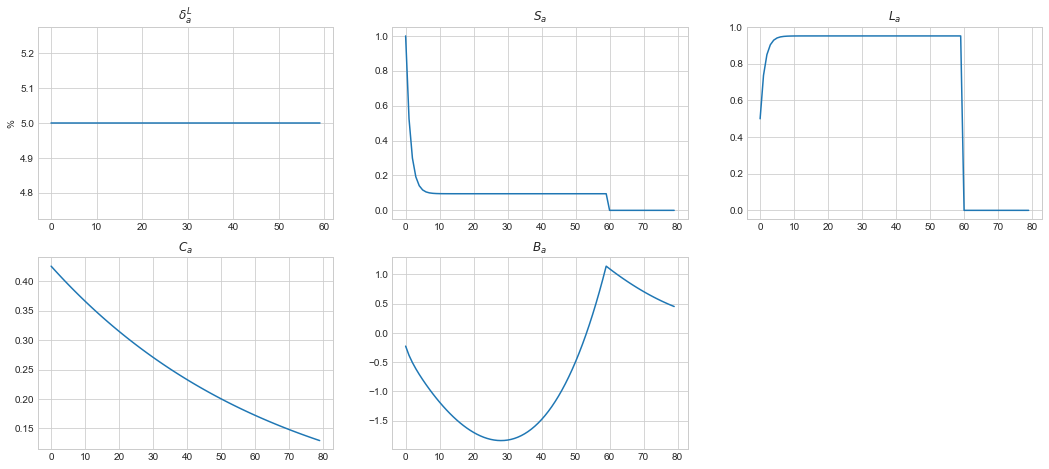

In [5]:
fig = plt.figure(figsize=(3*6,3*6/1.5))

ax = fig.add_subplot(3,3,1)
ax.plot(model.par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('$\delta^L_a$')

ax = fig.add_subplot(3,3,2)
ax.plot(model.ss.S_a)
ax.set_title('$S_a$')

ax = fig.add_subplot(3,3,3)
ax.plot(model.ss.L_a)
ax.set_title('$L_a$')

ax = fig.add_subplot(3,3,4)
ax.plot(model.ss.C_a)
ax.set_ylabel('')
ax.set_title('$C_a$')

ax = fig.add_subplot(3,3,5)
ax.plot(model.ss.B_a)
ax.set_ylabel('')
ax.set_title('$B_a$');

# Speed and error tests

In [6]:
model.set_exo_ss()
model.set_unknowns_ss()

**Python evaluation:**

In [7]:
%time model.evaluate_blocks(py=True)

CPU times: user 8.14 s, sys: 230 ms, total: 8.37 s
Wall time: 21 s


**Check errors:**

In [8]:
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 4.44e-16
Bq_match            : abs. max = 3.86e-12
FOC_capital_agency  : abs. max = 2.22e-16
FOC_K_ell           : abs. max = 2.22e-16
FOC_E_Y_KL          : abs. max = 0.00e+00
mkt_clearing        : abs. max = 0.00e+00
output_price        : abs. max = 0.00e+00


**First numba evaluation:**

In [9]:
%time model.evaluate_blocks()

CPU times: user 1min, sys: 1.28 s, total: 1min 1s
Wall time: 1min 10s


**Time:**

In [10]:
%timeit model.evaluate_blocks()
%timeit model.get_errors()

11.3 ms ± 427 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
86.3 µs ± 7.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
%timeit model.evaluate_blocks(py=True)

655 ms ± 56.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Find an impulse-response

**Calculate Jacobian:**

In [12]:
model.calc_jac(do_print=True)

Jacobian calculated in 39.7 secs secs


Only needs to be calculated once.

**Set exogenous variables:**

In [13]:
model.set_exo_ss()

**Shock function:**

In [14]:
Tshock = 20
shock = 0.01*ss.P_M_C
persistence = 0.75**np.arange(Tshock)
sol.P_M_C[:Tshock] = ss.P_M_C + shock*persistence
sol.P_M_G[:Tshock] = ss.P_M_G + shock*persistence
sol.P_M_I[:Tshock] = ss.P_M_I + shock*persistence
sol.P_M_X[:Tshock] = ss.P_M_X + shock*persistence
sol.P_F[:Tshock] = ss.P_F + shock*persistence

Check errors when guessing at steady state -> excess demand

In [15]:
model.set_unknowns_ss()
model.evaluate_blocks()
errors = model.get_errors(do_print=True)

bargaining_cond     : abs. max = 2.22e-16
Bq_match            : abs. max = 6.01e-02
FOC_capital_agency  : abs. max = 1.16e-03
FOC_K_ell           : abs. max = 2.22e-16
FOC_E_Y_KL          : abs. max = 5.55e-17
mkt_clearing        : abs. max = 4.97e+00
output_price        : abs. max = 0.00e+00


**Find IRF:**

In [16]:
model.find_IRF()

initial:
   max. abs. error = 4.97e+00
    2.22e-16 in bargaining_cond
    6.01e-02 in Bq_match
    1.16e-03 in FOC_capital_agency
    2.22e-16 in FOC_K_ell
    5.55e-17 in FOC_E_Y_KL
    4.97e+00 in mkt_clearing
    0.00e+00 in output_price

it = 0
 solve: t1-t0 = 1.0 secs
   max. abs. error = 4.97e+00
    6.58e-04 in bargaining_cond
    9.06e-03 in Bq_match
    5.97e-05 in FOC_capital_agency
    3.86e-04 in FOC_K_ell
    1.94e-04 in FOC_E_Y_KL
    7.29e-02 in mkt_clearing
    3.51e-04 in output_price
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 1
 solve: t1-t0 = 1.2 secs
   max. abs. error = 7.29e-02
    1.11e-04 in bargaining_cond
    9.83e-04 in Bq_match
    3.43e-06 in FOC_capital_agency
    4.77e-05 in FOC_K_ell
    3.05e-05 in FOC_E_Y_KL
    2.43e-03 in mkt_clearing
    5.84e-05 in output_price
 evaluate: t1-t0 = 0.0 secs
 update_jac: t1-t0 = 0.1 secs

it = 2
 solve: t1-t0 = 1.1 secs
   max. abs. error = 2.43e-03
    2.03e-06 in bargaining_cond
    5.62e-05 in

**Plot:**

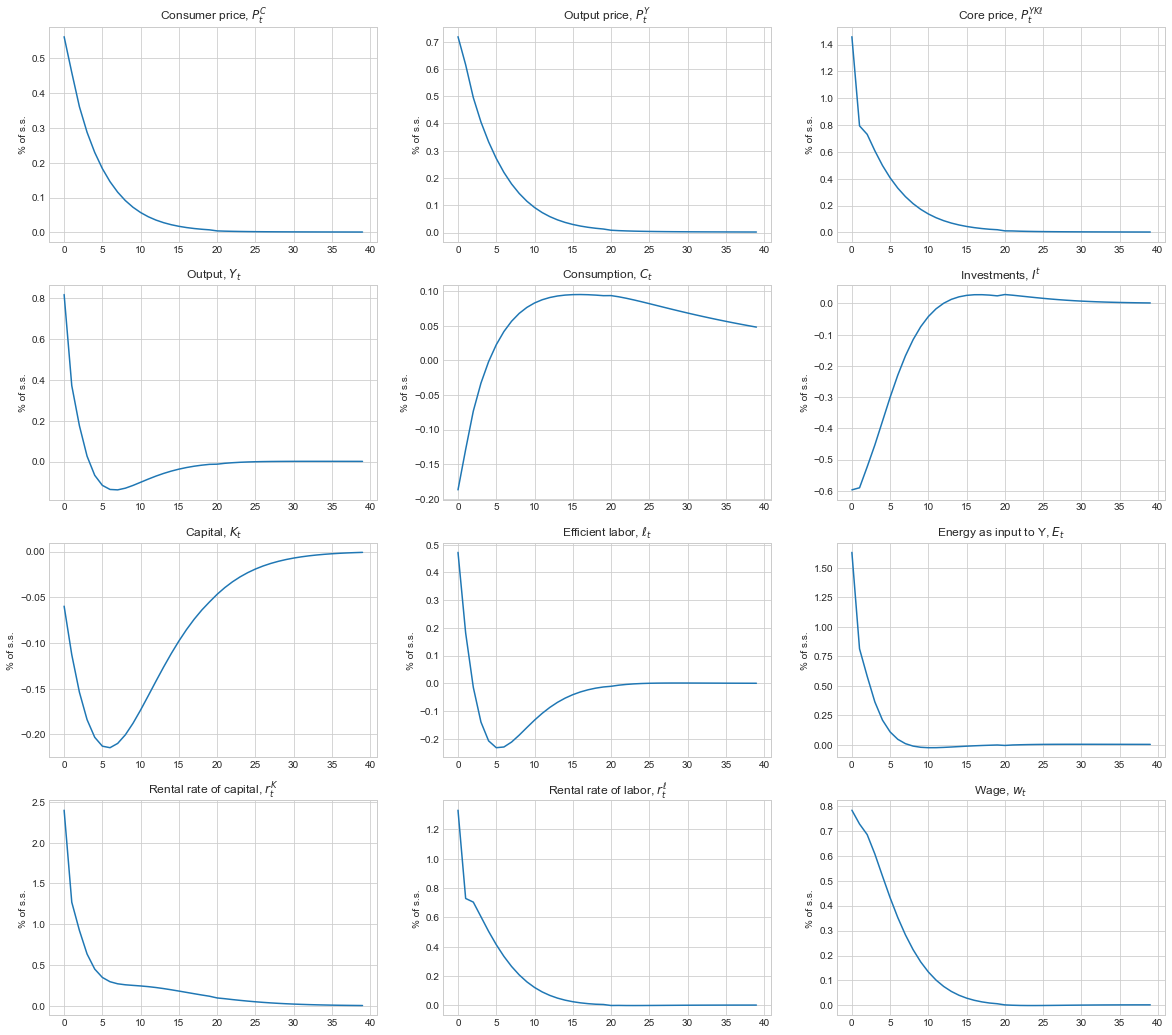

In [17]:
T_IRF = 40

fig = plt.figure(figsize=(20,20/1.1))

ax = fig.add_subplot(4,3,1)
ax.plot((sol.P_C[:T_IRF]/ss.P_C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumer price, $P_t^C$')

ax = fig.add_subplot(4,3,2)
ax.plot((sol.P_Y[:T_IRF]/ss.P_Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Output price, $P_t^Y$')

ax = fig.add_subplot(4,3,3)
ax.plot((sol.P_Y_KL[:T_IRF]/ss.P_Y_KL-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Core price, $P_t^{YK\ell}$')

ax = fig.add_subplot(4,3,4)
ax.plot((sol.Y[:T_IRF]/ss.Y-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Output, $Y_t$')

ax = fig.add_subplot(4,3,5)
ax.plot((sol.C[:T_IRF]/ss.C-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Consumption, $C_t$')

ax = fig.add_subplot(4,3,6)
ax.plot(((sol.I[:T_IRF])/(ss.I)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Investments, $I^t$');

ax = fig.add_subplot(4,3,7)
ax.plot(((sol.K[:T_IRF])/(ss.K)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Capital, $K_t$');

ax = fig.add_subplot(4,3,8)
ax.plot(((sol.ell[:T_IRF])/(ss.ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Efficient labor, $\ell_t$');

ax = fig.add_subplot(4,3,9)
ax.plot(((sol.E[:T_IRF])/(ss.E)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Energy as input to Y, $E_t$');

ax = fig.add_subplot(4,3,10)
ax.plot(((sol.r_K[:T_IRF])/(ss.r_K)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Rental rate of capital, $r_t^K$');

ax = fig.add_subplot(4,3,11)
ax.plot(((sol.r_ell[:T_IRF])/(ss.r_ell)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Rental rate of labor, $r_t^{\ell}$');

ax = fig.add_subplot(4,3,12)
ax.plot(((sol.w[:T_IRF])/(ss.w)-1)*100)
ax.set_ylabel('% of s.s.')
ax.set_title('Wage, $w_t$');

plt.savefig('2_foreign_prices.png')